# ARIM-Academy：　ラマンスペクトル分析ライブラリ RamanSPy
### RamanSPyを用いた基本的なラマンスペクトルの前処理とパイプライン化

## 本編の目標

この講義では、RamanSPyライブラリを用いてラマン分光データの読み込み、前処理、分析、可視化という一連の処理を一気通貫で進める方法を学びます。具体的には、データファイルの読み込みから始まり、スペクトルのトリミング、宇宙線除去、ノイズ除去、ベースライン補正、正規化といった一連の前処理操作をカバーします。最後に、再現性のある前処理を容易かつ一気通貫で効率的に行うためのパイプライン機能についても習得します。

---

### RamanSPyとは

RamanSPyは2024年にインペリアル・カレッジ・ロンドンのM. Barahona教授らのグループによってリリースされたラマン分光法のスペクトル分析、データ分析、手法開発、統合分析などを支援するオープンソースのPythonライブラリです。機械学習ライブラリとも容易に連携できる特徴を持っています。

<br>  
<img src="./img/images_medium_ac4c00383_0006.gif" width="50%"><br> 

---

### RamanSPy主な特徴

1. **完全なワークフローサポート**:
   - データの読み込み、前処理、分析、可視化までの全プロセスを一貫してサポートし、異なるデータ形式や機器に依存せずに使用できます。

2. **前処理パイプライン**:
   - 複雑な前処理パイプラインを効率よく構築・実行できるメソッドを提供し、一貫した前処理を自動化・再現可能にします。

3. **統合分析**:
   - Pythonの他のライブラリとスムーズに統合でき、AI・MLツールとの連携をサポートします。

4. **モデル開発**:
   - 様々なデータセットやモデル評価指標を用意し、新しいアルゴリズムやAIベースの手法を効率的に開発・評価することができます。

### 文献

[1] Georgiev, D.; Pedersen, S. V.; Xie, R.; Fernández-Galiana, Á.; Stevens, M. M.; Barahona, M. RamanSPy: An open-source Python package for integrative Raman spectroscopy data analysis. ACS Analytical Chemistry 2024, 96(21), 8492-8500, DOI: 10.1021/acs.analchem.4c00383

### 教材への接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!pip install ramanspy
!git clone https://github.com/ARIM-Academy/Advanced_Tutorial_2_RamanSpy.git
%cd Advanced_Tutorial_2_RamanSpy

## 1.データセットの読み込みとスペクトル表示

### ライブラリのインポート
カリキュラムで扱うpythonのライブラリをimport文でロードします。 機械学習のライブラリであるscikit-learnは後半でimportします。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### スペクトルデータの読み込み
「data」フォルダーにあるPLAS 260 532 nm.csvをpandasの`read_csv()`からデータフレーム（DataFrame）として変数dfに格納します。この時、スペクトルに寄与しないメタデータの記載のある1行目は不要であるため、`skiprows`オプションで1行目をスキップさせています。

In [4]:
#csv形式のスペクトルの読み込み
df = pd.read_csv("./data/PLAS 260 532 nm.csv", skiprows=1)
df

,Raman Shift / cm-1,INT
0,3418.58,-87
1,3417.61,-51
2,3416.65,-37
3,3415.68,-32
4,3414.72,-2
...,...,...
3462,80.40,-15
3463,79.44,-30
3464,78.47,-37
3465,77.51,-35


### スペクトルの可視化（Matplotlib）
PandasのDataFrame形式で与えられたラマンスペクトルデータをMatplotlibを用いて可視化します。matplotlibのplot関数よりX軸に["Raman Shift / cm-1"]、Y軸に["INT"]を指定し、ラマンスシフトを横軸、強度を縦軸としたグラフを描画します。

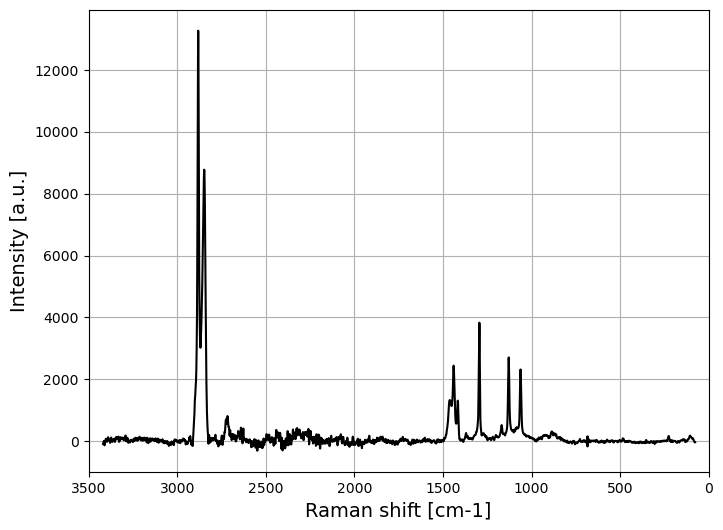

In [7]:
# ラマンスペクトル
fig, ax = plt.subplots(figsize=(8,6))

X = df["Raman Shift / cm-1"]
Y = df["INT"]

#スペクトル表示
plt.plot(X, Y, 
         color ='black')

#ラベル名
plt.xlabel("Raman shift [cm-1]", fontsize =14)
plt.ylabel("Intensity [a.u.]", fontsize =14)

# Xの範囲
plt.xlim(0, 3500)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

## 2. RamanSPyを使ったスペクトル処理
ここではRamanSPyライブラリを使って、スペクトルの事前処理を行います。事前に`pip install ramanspy`でライブラリをインストールされていることを前提に、次のramanspyをインポートします。

### ライブラリのインポート
RamanSPyのimportでは次のように短縮名（エイリアス名）は`rp`と記述することがチュートリアルでは示されています。

In [15]:
import ramanspy as rp

### RamanSPyにおけるスペクトルのオブジェクト定義
RamanSPyではcsvファイルを直接扱えないため、処理可能なオブジェクトへ変換する関数を用意します。ここではユーザー定義関数のdefから`read_csv()`関数を定義し、csvで提供されるラマンスペクトルを読み取り、ramanSPyのSpectrum()メソッドでオブジェクト化して返します。

In [18]:
def read_csv(csv_filename, skiprows):
    data = pd.read_csv(csv_filename, skiprows=skiprows)

    X = data["Raman Shift / cm-1"]
    Y = data["INT"]

    raman_spectrum = rp.Spectrum(Y, X)

    return raman_spectrum

### スペクトルの可視化(RamanSPy)

「data」フォルダーにあるPLAS 260 532 nm.csvを上記で定義した`read_csv()`関数からramanSPyオブジェクトとして変数spectraに格納します。スペクトルに寄与しないメタデータの記載のある1行目は不要であるため、`skiprows`オプションで1行目をスキップさせています。

In [21]:
data = read_csv("./data/PLAS 260 532 nm.csv", skiprows=1)

In [23]:
data

### 1. スペクトル表示

RamanSPyは、様々なラマン分光データや分析結果を視覚化するためのツールを提供しています。これには、スペクトルや画像データ、体積データの可視化、さらに関連する統計情報（例: 平均スペクトルやピーク強度の分布）などが含まれます。  
詳細は、[Data Visualisation](https://ramanspy.readthedocs.io/en/latest/plot.html)をご覧ください。

### スペクトルの作図
#### メソッド: `ramanspy.plot.spectra()`

`ramanspy.plot.spectra()`は、RamanSPyでスペクトルを可視化するためのメソッドです。スペクトルオブジェクトを引数に渡すことでプロットを生成します。バックグランドではmatplotlibが動作しているため、軸やラベルの調整など、matplotlibの機能を使ってレイアウトをデザインできます。

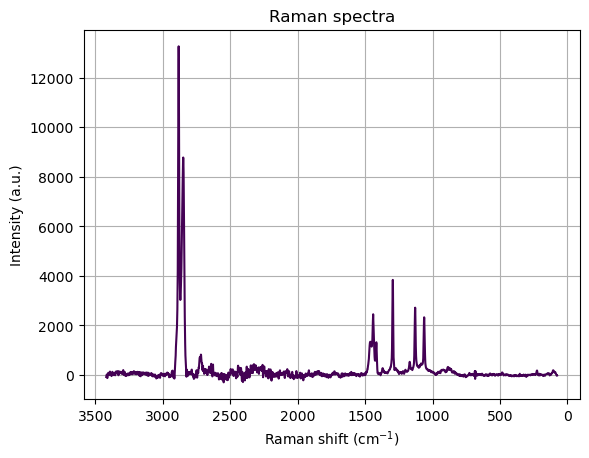

In [27]:
rp.plot.spectra(data)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### 【解説】ramanspy.plot.spectra()メソッド  

ramanspy.plot.spectra()では、下記のオプションがあります。

**spectra** (Union[NDArray, SpectralObject, List[Union[NDArray, SpectralObject]], List[List[Union[NDArray, SpectralObject]]]]) – プロットするスペクトルデータ。単一のスペクトルや複数のスペクトルのコレクションをプロットできます。SpectralObject は Union[SpectralContainer, Spectrum, SpectralImage, SpectralVolume] を意味します。

**wavenumber_axis** (numpy.ndarray, optional) – 提供されたデータのシフト軸。スペクトルにスペクトルコンテナでないデータが含まれている場合にのみ使用されます。すべてのスペクトルで一致している必要があります。

**plot_type** ({"single", "separate", "stacked", "single stacked"}, optional) – プロットの種類。デフォルトは 'separate' です。

- 'single' - グループを同じプロットにプロットします。
- 'separate' - グループを個別のプロットにプロットします。
- 'stacked' - グループを個別のプロットに重ねてプロットします。
- 'single stacked' - グループを同じプロットに重ねてプロットします。

**title** (str, optional) – プロットのタイトル。デフォルトは 'Raman spectra'。

**xlabel** (str, optional) – プロットのX軸ラベル。デフォルトは 'Raman shift (cm$^{-1}$)'。

**ylabel** (str, optional) – プロットのY軸ラベル。デフォルトは 'Intensity (a.u.)'。

**label** (Union[str, List[str]], optional) – 提供されたスペクトルグループのラベル。スペクトルに対応する必要があります。デフォルトは None で、ラベルは付きません。

**color** (Union[str, List[str]], optional) – 各プロットに使用する色。デフォルトは None で、デフォルトのmatplotlibのカラーマップ（veridisカラーマップ）が使用されます。

**kwargs** – 追加のパラメータ。matplotlib.pylot.plot メソッドに渡されます。


#### 【例】RamanSpy形式とMatplotlibを併用したスペクトル作図

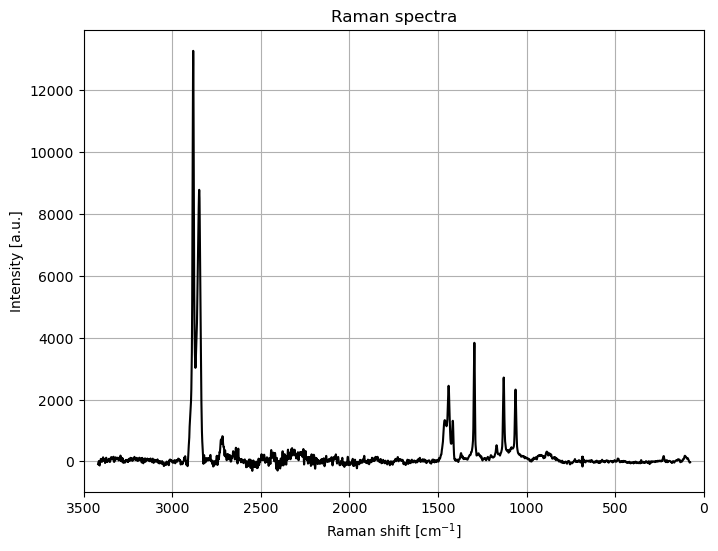

In [31]:
# ラマンスペクトル
fig, ax = plt.subplots(figsize=(8,6))

rp.plot.spectra(data,
                xlabel = 'Raman shift [cm$^{-1}$]',
                ylabel = 'Intensity [a.u.]',
                color = 'black'
               )
                
# Xの範囲
plt.xlim(0, 3500)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### ピーク検出
#### メソッド: `ramanspy.plot.peaks()`

`ramanspy.plot.peaks()`は、RamanSPyでスペクトルを可視化しながらピーク検出を行うためのメソッドです。このメソッドにスペクトルオブジェクトを渡すと、スペクトルがプロットされ、ピークが検出されます。可視化にはmatplotlibが使用されており、ピーク検出にはScipyの`signal.find_peaks()`メソッドが利用されています。

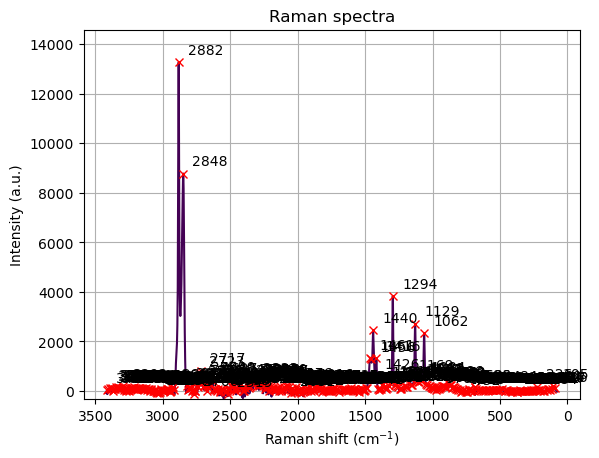

In [34]:
rp.plot.peaks(data)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### 【解説】`ramanspy.plot.peaks()`メソッド  

`ramanspy.plot.peaks()`は、スペクトルを表示し、ピークを検出するためのメソッドです。以下のオプションが利用可能です。これらのオプションは、SciPyライブラリの`scipy.signal.find_peaks`メソッドを利用しており、1次元データ配列からピークを検出します。

- **spectrum** (Spectrum) – プロットするスペクトルデータ。

- **title** (str, optional) – プロットのタイトル。デフォルトは 'Raman spectra'。

- **xlabel** (str, optional) – プロットのX軸ラベル。デフォルトは 'Raman shift (cm$^{-1}$)'。

- **ylabel** (str, optional) – プロットのY軸ラベル。デフォルトは 'Intensity (a.u.)'。

- **color** (matplotlib color, optional) – プロットに使用する色。デフォルトはmatplotlibのデフォルトカラーマップ（viridisカラーマップ）。

- **height** (tuple, optional) – ピークの高さの最小値と最大値を指定します。`(min, max)`の形式で範囲を設定します。

- **threshold** (float, optional) – 近傍のデータとの差が指定値以上である必要があります。これにより、小さなピークを無視できます。

- **distance** (float, optional) – ピーク間の最小距離を指定します。これにより、特定の間隔以下のピークが一つにまとめられます。

- **prominence** (float, optional) – ピークのプロミネンス（突出度）の最小値を指定します。プロミネンスは、ピークの高さとその両側の最も低い点との高さの差です。

- **width** (float, optional) – ピークの幅の最小値を指定します。

- **rel_height** (float, optional) – ピークの高さの割合としてのプロミネンスの基準。デフォルトは0.5です。

- **plateau_size** (float, optional) – ピークがフラットな頂点を持つ場合、そのサイズを指定します。

- **return_peaks** (bool, optional) – ピークとその特性を返すかどうか。デフォルトはFalse。

- **plt_kwargs** – 追加のパラメータ。`matplotlib.pyplot.plot`メソッドに渡されます。


#### 【例】Intensityが1000以上のピークのみを検出

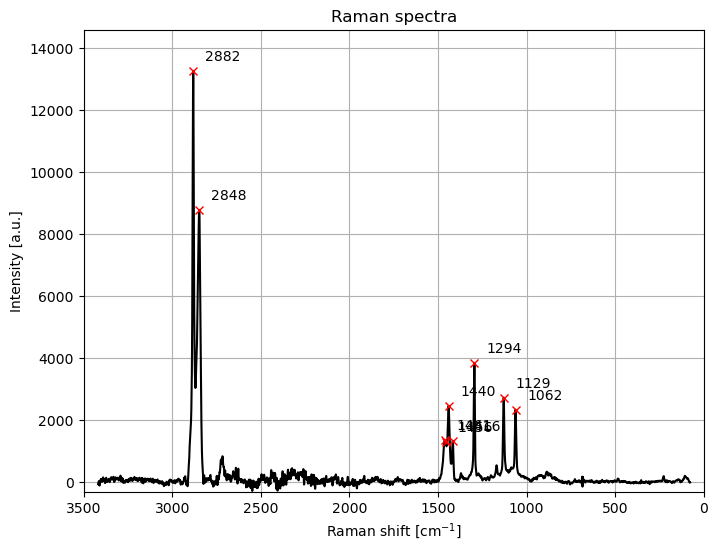

In [38]:
# ラマンスペクトル
fig, ax = plt.subplots(figsize=(8,6))

# Intensityが1000以上のピークのみを検出
rp.plot.peaks(data,
                xlabel = 'Raman shift [cm$^{-1}$]',
                ylabel = 'Intensity [a.u.]',
                color = 'black',
                height= 1000
               )
                
# Xの範囲
plt.xlim(0, 3500)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### 2. スペクトル処理

RamanSPyは、ベースライン補正、クロッピング、デノイズ、平滑化などの一般的なスペクトル前処理手法を提供し、複雑な前処理を効率的に実行できます。さらに、RamanSPyに組み込まれているパッケージを使用して、カスタムの前処理アルゴリズムやパイプラインを定義することも可能です。  
詳細は [前処理](https://ramanspy.readthedocs.io/en/latest/preprocessing.html) を参照してください。

### クロッピング（Cropping）
#### メソッド：`ramanspy.preprocessing.misc.Cropper(range)`
**機能**： 指定された範囲のバンドに関連する強度値とシフト軸を切り取ります。  
**解説**： 「バンド範囲」とは、ラマンシフト軸上の特定の範囲を指します。ラマン分光スペクトルでは、ラマンシフト（通常cm⁻¹で表される）に対して強度（信号の強さ）がプロットされます。特定の化学的特徴や関心のある情報は、スペクトルの特定のシフト範囲に存在することが多いため、その範囲だけを抽出して分析することがよく行われます。

#### 設定

`rp.preprocessing.misc.Cropper` メソッドを使用して、クロップするオブジェクトを作成します。ここでは、クロッピングの範囲（「バンド範囲」）を500〜3000 cm⁻¹に設定します。

In [43]:
#バンド範囲の指定とオブジェクト化
cropper = rp.preprocessing.misc.Cropper(region=(500, 3000))
cropped_data = cropper.apply(data)

#### 作図

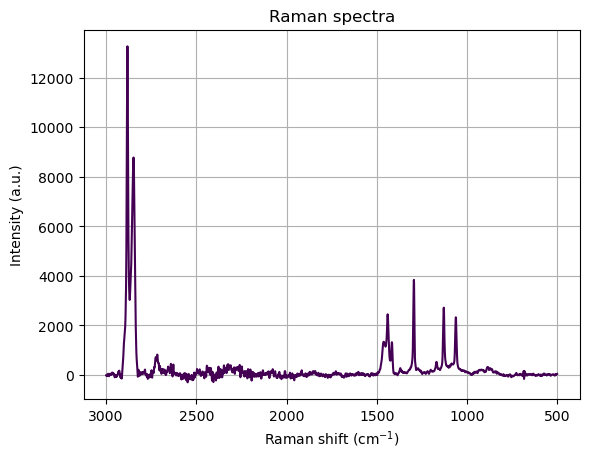

In [46]:
rp.plot.spectra(cropped_data)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### 3. 宇宙線の除去（Cosmic Ray Removal）

#### メソッド：`ramanspy.preprocessing.despike.WhitakerHayes(kernel_size)`

**機能**: 修正Zスコアフィルタリングに基づき、データ中の宇宙線によるスパイクを除去します。  
**解説**: 宇宙線はデータ中に急激なスパイクとして現れ、分析結果に悪影響を及ぼすことがあります。これを除去するために、修正Zスコアフィルタリングが用いられます。修正Zスコアフィルタリングは、統計的手法で異常値を検出して除去します。具体的には、データポイントの修正Zスコア（標準スコア）が設定した閾値を超えた場合、そのデータポイントを異常値（宇宙線によるスパイク）とみなし、除去または修正します。

#### 設定
`rp.preprocessing.despike.WhitakerHayes` メソッドを使用して、宇宙線を除去するオブジェクトを作成します。このメソッドの設定には、カーネルサイズ（`kernel_size`）を指定する必要があります。カーネルサイズは、スパイク検出に使用するウィンドウのサイズを決定します。以下はその設定方法の例です。

In [50]:
despike = rp.preprocessing.despike.WhitakerHayes(kernel_size=5)
removed_data = despike.apply(data)

#### 作図

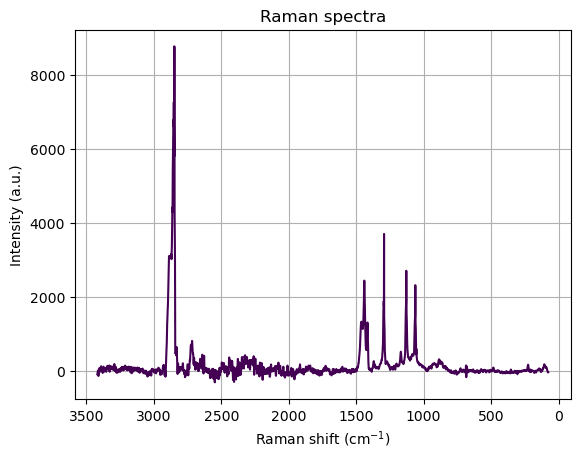

In [53]:
rp.plot.spectra(removed_data)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### 4. ノイズ除去（Denoising）

ラマン分光データの前処理において、ノイズ除去とスムーシングは重要なステップです。これらの処理は、データの精度と信頼性を向上させるために、スペクトルデータから不要なノイズを取り除き、基礎となる信号の特徴を明瞭にすることを目的としています。

- **ノイズ除去**: データ中の不要な変動や外れ値を取り除くプロセスです。これにより、データの品質が向上します。
- **スムーシング**: データを滑らかにすることでランダムなノイズを低減し、データの基本的なトレンドやパターンを明確にします。

これらのプロセスにより、ノイズの影響を最小限に抑え、信号対ノイズ比を向上させることができます。

RamanSPyでは、以下の4つのフィルタ（スムーシング手法）が用意されています：
* **Savitzky-Golayフィルタ**: データのスムーズなフィッティングを提供します。
* **離散ペナルティ最小二乗法（Whittaker-Henderson smoothing）**: データの平滑化に用います。
* **カーネル/ウィンドウスムーザー**: 特定のカーネルやウィンドウを用いたスムーシングを行います。
* **ガウシアンフィルタ**: データの平滑化にガウス関数を使用します。

### Savitzky-Golayフィルタ
#### メソッド：`ramanspy.preprocessing.denoise.SavGol(window_size, polynomial_order)`

**機能**: Savitzky-Golayフィルタリングによるノイズ除去を行います。

**解説**: Savitzky-Golayフィルタリング（Savitzky-Golay filtering）は、データの滑らかな曲線を保持しつつノイズを低減するために広く使用される手法です。特にラマン分光や赤外分光などのスペクトルデータにおいて、信号の形状を維持しながらランダムなノイズを減少させるのに適しています。この手法では、指定したウィンドウサイズ内でデータの多項式フィッティングを行い、その多項式を用いてデータを滑らかにします。　

### 設定

- **ウィンドウサイズ（window size）**: 平滑化に使用するデータポイントの数を指定します。奇数でなければなりません。ウィンドウサイズが大きいほど平滑化の効果が強くなりますが、データの特徴的な部分も平滑化されるリスクがあります。

- **多項式の次数（polynomial order）**: フィッティングに使用される多項式の次数を指定します。次数が高いほど、データの微細な特徴をより良く保持できます。

In [58]:
Window_length=15
Polyorder=3

sg_filter = rp.preprocessing.denoise.SavGol(window_length= Window_length, polyorder=Polyorder)
sg_filtered = sg_filter.apply(data)

#### 作図

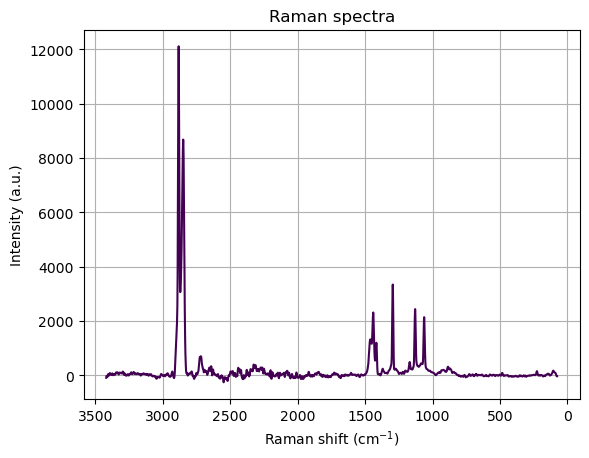

In [61]:
rp.plot.spectra(sg_filtered)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### Discrete Penalised Least Squares (別名 Whittaker−Henderson スムージング)
#### メソッド：`ramanspy.preprocessing.denoise.Whittaker(*[, lam, d])`

**機能**: 離散ペナルティ付き最小二乗法（Whittaker−Hendersonスムージング）によるノイズ除去。

**解説**: 離散ペナルティ付き最小二乗法（Discrete Penalised Least Squares, DPLS）は、データのノイズを低減し、滑らかなトレンドを強調するスムージング技術で、特に時間系列データやスペクトルデータに適しています。この手法は、データの平滑化を行いながら、元のデータとの二乗差を最小化します。ペナルティ項を追加することで、データの変動を抑え、滑らかな結果を得ることができます。DPLSはWhittaker−Hendersonスムージングとも呼ばれます。

#### 設定

- **`lam`（ラムダ）**: 平滑化パラメータ。大きい値を設定するとスムージングの効果が強くなり、データがより滑らかになります。一方、`lam`が小さいと、データの詳細をより多く保持します。適切な`lam`の選択は、ノイズ除去の効果とデータの特徴保持とのバランスを取るために重要です。

- **`d`（差分行列）**: スムージングに使用される差分行列で、通常は2次の差分行列が使用されます。差分行列はデータの滑らかさを測定するために使用され、データの急激な変動を抑えるのに役立ちます。

In [65]:
lam = 1000
d = 2

dpls = rp.preprocessing.denoise.Whittaker(lam = lam, d = d)
dpls_filtered = dpls.apply(data)

#### 作図

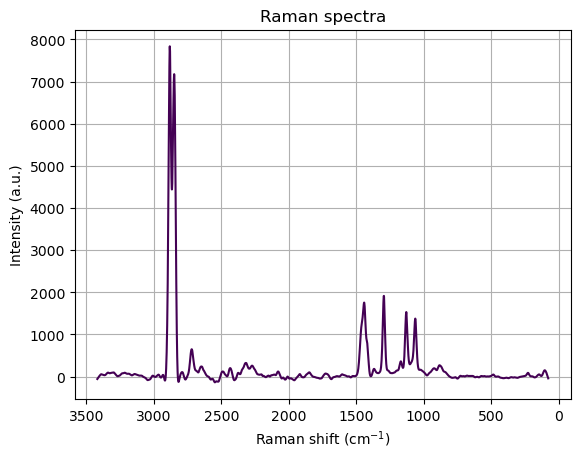

In [67]:
rp.plot.spectra(dpls_filtered)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### Kernel/Window smoothers
#### メソッド：`ramanspy.preprocessing.denoise.Kernel(*, kernel_type[, kernel_size])`

**機能**: Kernel/Windowスムーザーによるノイズ除去。

**解説**: Kernel/Windowスムーザーは、データのスムージングとノイズ除去に広く用いられる手法です。このアプローチでは、各データポイントに対して、その周囲のデータポイントの加重平均を計算し、新しい値を生成することで、滑らかな曲線を作成します。これにより、ランダムなノイズを減少させ、データの基本的なトレンドを明確にすることができます。Kernel/Windowスムーザーは、データの各点に「カーネル関数」または「ウィンドウ関数」と呼ばれる重み付け関数を適用し、近傍のデータポイントに基づいてスムージングを行います。

In [71]:
kernel = rp.preprocessing.denoise.Kernel(kernel_type='flat', kernel_size=5)
kernel_filtered = kernel.apply(data)

#### 作図

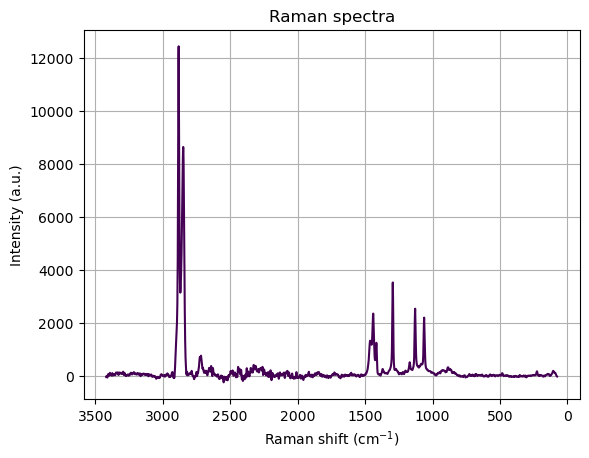

In [74]:
rp.plot.spectra(kernel_filtered)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### Gaussian filter
#### メソッド：`rp.preprocessing.denoise.Gaussian(*[, sigma, order, output, ...])`

**機能**：Gaussianフィルタによるノイズ除去。

**解説**：Gaussianフィルタは、画像処理や信号処理で広く用いられるノイズ除去手法です。このフィルタは、データの各点にガウス関数（正規分布）に基づく重みを適用し、その周囲のデータポイントの加重平均を計算することでデータを平滑化します。具体的には、中心からの距離が遠いほど重みが小さくなり、ガウス関数の特性によって滑らかなノイズ低減を実現します。これにより、データの基本的なトレンドやパターンを保持しつつ、ランダムなノイズを効果的に除去することができます。

In [77]:
gauss = rp.preprocessing.denoise.Gaussian() 
gauss_filtered = gauss.apply(data)

#### 作図
平滑化されていることが確認できます。

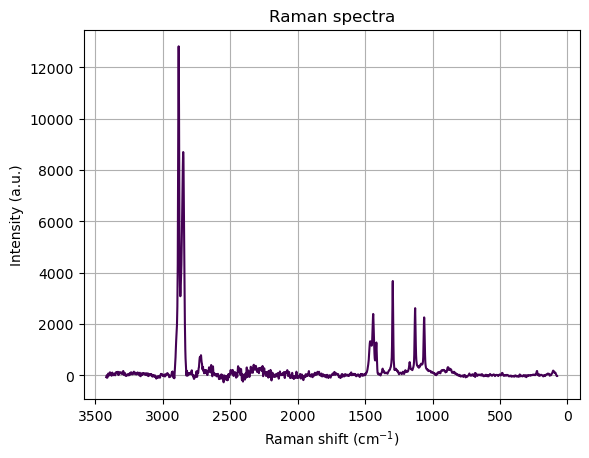

In [80]:
rp.plot.spectra(gauss_filtered)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()


### 5. ベースライン補正

RamanSPy では、様々なベースライン補正手法が用意されており、スペクトルデータの基準線を補正するための柔軟なアプローチが提供されています。以下に、利用可能なベースライン補正の方法を示します。

#### Polynomial Fitting
- **Polynomial Fitting**: 多項式を使用してベースラインをフィットさせる方法です。
- **Modified Polynomial Fitting**: 改良された多項式フィッティング手法で、より正確な補正が可能です。

#### Least Squares
- **Asymmetric Least Squares (AsLS)**: 非対称な最小二乗法を用いて、データのベースラインを補正します。
- **Improved Asymmetric Least Squares (IAsLS)**: AsLS の改良版で、より精度の高い補正が可能です。
- **Adaptive Iteratively Reweighted Penalized Least Squares (airPLS)**: 繰り返し重み付けを用いた適応型のペナルティ付き最小二乗法です。
- **Asymmetrically Reweighted Penalized Least Squares (arPLS)**: 非対称に重み付けされたペナルティ付き最小二乗法です。
- **Doubly Reweighted Penalized Least Squares (drPLS)**: 二重に重み付けされたペナルティ付き最小二乗法です。
- **Improved Asymmetrically Reweighted Penalized Least Squares (IarPLS)**: 改良された非対称重み付きペナルティ最小二乗法です。
- **Adaptive Smoothness Penalized Least Squares (asPLS)**: 適応的スムージングを用いたペナルティ付き最小二乗法です。

#### Other
- **Goldindec**: 特定のアルゴリズムによるベースライン補正手法です。
- **Iterative Reweighted Spline Quantile Regression (IRSQR)**: スプラインと分位点回帰を用いた繰り返し重み付け手法です。
- **Corner Cutting**: ベースライン補正のための角切り手法です。
- **Fully Automatic Baseline Correction (FABC)**: 完全自動でベースラインを補正する手法です。

これらの方法は、それぞれ異なるアプローチでベースラインの補正を行い、スペクトルデータの分析精度を向上させることができます。選択する手法は、データの特性や目的に応じて適切に決定してください。

### Adaptive Smoothness Penalized Least Squares (asPLS)
#### メソッド：`rp.preprocessing.baseline.ASLS(*, lam=1000000.0, p=0.01, diff_order=2, max_iter=50, tol=0.001, weights=None)`

**機能**：非対称最小二乗法（AsLS）に基づくベースライン補正。

**解説**：
非対称最小二乗法（AsLS）に基づくベースライン補正は、ラマン分光データのベースライン（基線）を補正するための手法です。ラマン分光データには、測定機器や環境条件により、実際の信号以外に不要な背景信号（ベースライン）が含まれることがあります。このベースラインがデータに影響を与えると、スペクトルのピークやその他の特徴の解析が難しくなります。AsLS法は、このベースラインを効果的に除去するために用いられ、データの精度を向上させることができます。

#### 設定
以下は、データ処理におけるベースライン補正のためのパラメータについての解説です。

1. **`data`** (array-like, shape (N,))  
   **説明**: 測定データのy値。N個のデータポイントを含む配列である必要があります。データには欠損値（NaN）や無限大（Inf）が含まれていてはいけません。

2. **`lam`** (float, optional)  
   **説明**: スムージングパラメータ。値が大きいほど、ベースラインがより滑らかになります。デフォルトは 1e6 です。

3. **`p`** (float, optional)  
   **説明**: ペナルティ加重係数。0と1の間の値でなければなりません。ベースラインより大きい値には `p` の重みが、小さい値には `p - 1` の重みが適用されます。デフォルトは 1e-2 です。

4. **`diff_order`** (int, optional)  
   **説明**: 微分行列の階数。0より大きい必要があります。デフォルトは 2（2次微分行列）です。一般的には1または2が使用されます。

5. **`max_iter`** (int, optional)  
   **説明**: フィットの最大反復回数。デフォルトは 50 回です。

6. **`tol`** (float, optional)  
   **説明**: 収束基準。デフォルトは 1e-3 です。アルゴリズムが収束するための許容誤差を指定します。

7. **`weights`** (array-like, shape (N,), optional)  
   **説明**: 加重配列。デフォルトでは None が指定され、初期の加重はサイズ N の配列で全ての値が 1 に設定されます。

In [85]:
baseline = rp.preprocessing.baseline.ASPLS()
br_corr = baseline.apply(data)

#### 作図

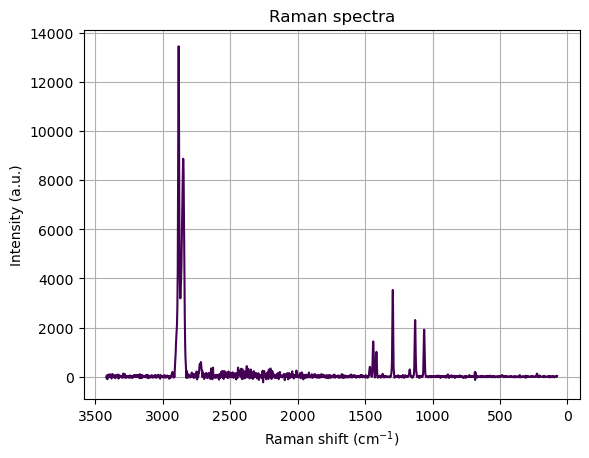

In [88]:
rp.plot.spectra(br_corr)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### 6. 規格化

RamanSPy では、次の 4 つの規格化手法が用意されています。

* **Vector normalisation**  
  ベクトルの長さを基準にデータを規格化します。

* **Min-max normalisation**  
  データを最小値と最大値の範囲内にスケーリングします。

* **Max intensity normalisation**  
  データの最大強度を基準に規格化します。

* **Area under the curve normalisation**  
  スペクトルの曲線下の面積を基準に規格化します。

### Vector normalisation
#### メソッド：`rp.preprocessing.normalise.Vector(*, pixelwise: bool = True)`

**機能**：  
データのベクトル長を基準に規格化します。具体的には、データ全体のベクトル長を 1 にスケーリングすることで、各データポイントがベクトル空間内で均等に分布するようにします。

**解説**：  
ベクトル規格化は、データの長さ（またはノルム）を 1 に設定する手法です。これにより、異なるスケールを持つデータ間での比較が可能になります。`pixelwise` パラメータが `True` に設定されている場合、データの各ピクセルが個別に規格化されます。デフォルトでは `pixelwise` が `True` に設定されており、これにより各データポイントが独立して規格化されます。

In [92]:
vn = rp.preprocessing.normalise.Vector()
init = vn.apply(data)

#### 作図

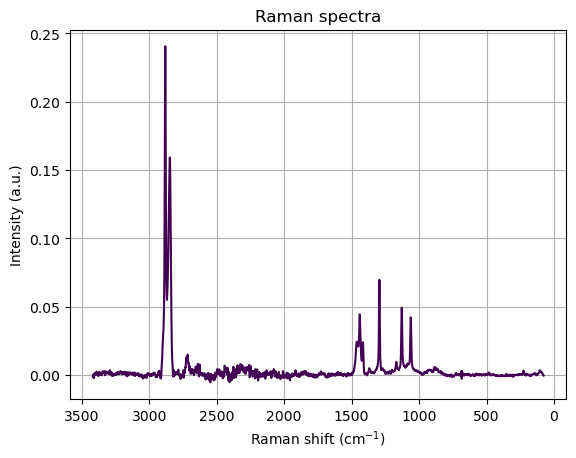

In [95]:
rp.plot.spectra(init)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

### Min-max normalisation
#### メソッド：`rp.preprocessing.normalise.MinMax(*, pixelwise: bool = True, a: Number = 0, b: Number = 1)`

**機能**：  
データの値を指定した範囲 `[a, b]` にスケーリングします。最小値が `a`、最大値が `b` に設定されるようにデータを規格化します。

**解説**：  
Min-max 正規化は、データの値を指定された最小値 (`a`) と最大値 (`b`) の範囲にスケーリングする方法です。これにより、データの値が新しい範囲 `[a, b]` に収まるように変換されます。`pixelwise` パラメータが `True` に設定されている場合、各データポイントが個別に規格化され、デフォルトでは `pixelwise` が `True` に設定されています。これにより、データの各ピクセル（またはポイント）が独立して規格化されます。

In [98]:
minmax = rp.preprocessing.normalise.MinMax()
init = minmax.apply(data)

#### 作図

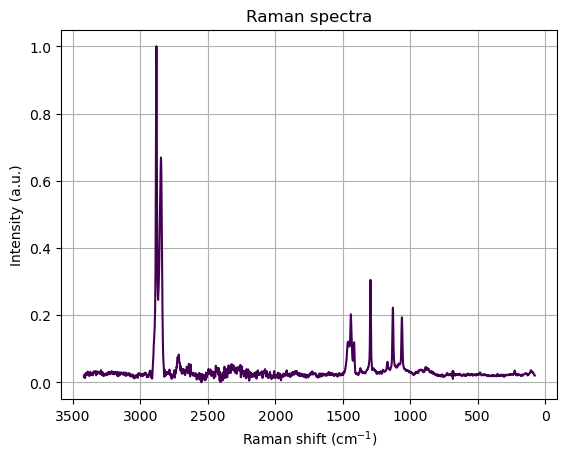

In [101]:
rp.plot.spectra(init)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()

## 3. パイプライン化

実験的なラマン分光データに対して複数の前処理手順を実施する必要があります。これらの手順を完了してから、分析を進めることが求められますが、複雑な前処理パイプラインの構築やカスタマイズは、使用するソフトウェアによって大きく異なります。RamanSPyはパイプラインツールを提供していますが、その中心的な機能が、`Pipeline` クラスの導入です。

### Pipelines
#### メソッド：`ramanspy.preprocessing.Pipeline(pipeline: List)`

**機能**：複数の前処理手順で構成される前処理パイプラインを定義します。  
**解説**：`Pipeline` クラスは、複数の前処理ステップを順序よく組み合わせて、ラマン分光データに適用するためのツールです。このクラスを使用することで、データ処理の一連の操作を効率よく管理し、自動化することができます。`pipeline` 引数には、適用する前処理手順をリスト形式で指定します。各ステップは、データに対する変換や処理を担当し、パイプライン内で順次実行されます。これにより、複雑な前処理のフローを簡潔に定義し、再利用可能な形で実装することが可能になります。

#### 設定

- **`raman_objects`**（型: `Union[SpectralObject, List[Union[SpectralObject, List[SpectralObject]]]]`）
  - **説明**: 前処理対象のオブジェクトを指定します。ここで、`SpectralObject` は次のいずれかのオブジェクトを指します:
    - `SpectralContainer`
    - `Spectrum`
    - `SpectralImage`
    - `SpectralVolume`
    
  `raman_objects` には、単一のオブジェクトまたはオブジェクトのリストを指定できます。リスト内には、`SpectralObject` の他に、さらに `SpectralObject` のリストを含むこともできます。この柔軟な指定方法により、さまざまな構造のデータに対して前処理を適用することができます。

In [106]:
spectra = read_csv("./data/PLAS 260 532 nm.csv", skiprows=1)

In [108]:
pipe = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(500,3000)),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length= Window_length, polyorder=Polyorder),
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MinMax()
])

# preprocess the spectra
pipelined_spectra = pipe.apply(spectra)

#### 作図

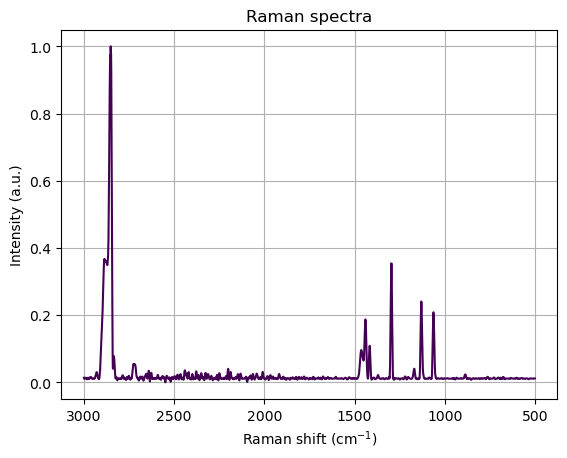

In [111]:
# plot the results
rp.plot.spectra(pipelined_spectra)

# X軸の範囲を反転
plt.gca().invert_xaxis()

plt.grid()
plt.show()